In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

import ema_workbench
from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator, ema_logging)

## 1. Loading the scenario dataset

In [2]:
n_scenarios = 1000
seed = 1234

scenarios_data = pd.read_csv(f"data/drought_scenarios_{n_scenarios} - seed{seed}.csv")
scenarios_data.head()

,calderon_flow,chapala_flow,pozos_flow,toluquilla_flow,zapotillo_flow,scenario,policy,model
0,0.960307,4.252350,0.304787,0.861636,0.329354,13504,None,AMGmodel
1,0.575665,2.127411,1.394283,0.346133,0.865325,72599,None,AMGmodel
2,0.820116,5.825276,0.557090,0.926341,0.381042,42217,None,AMGmodel
3,0.674427,5.887937,1.084134,0.045184,0.658394,97650,None,AMGmodel
4,1.169877,6.350443,1.032403,0.329324,0.704051,99120,None,AMGmodel


c:\Users\ariel\anaconda3\envs\MBWSA\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


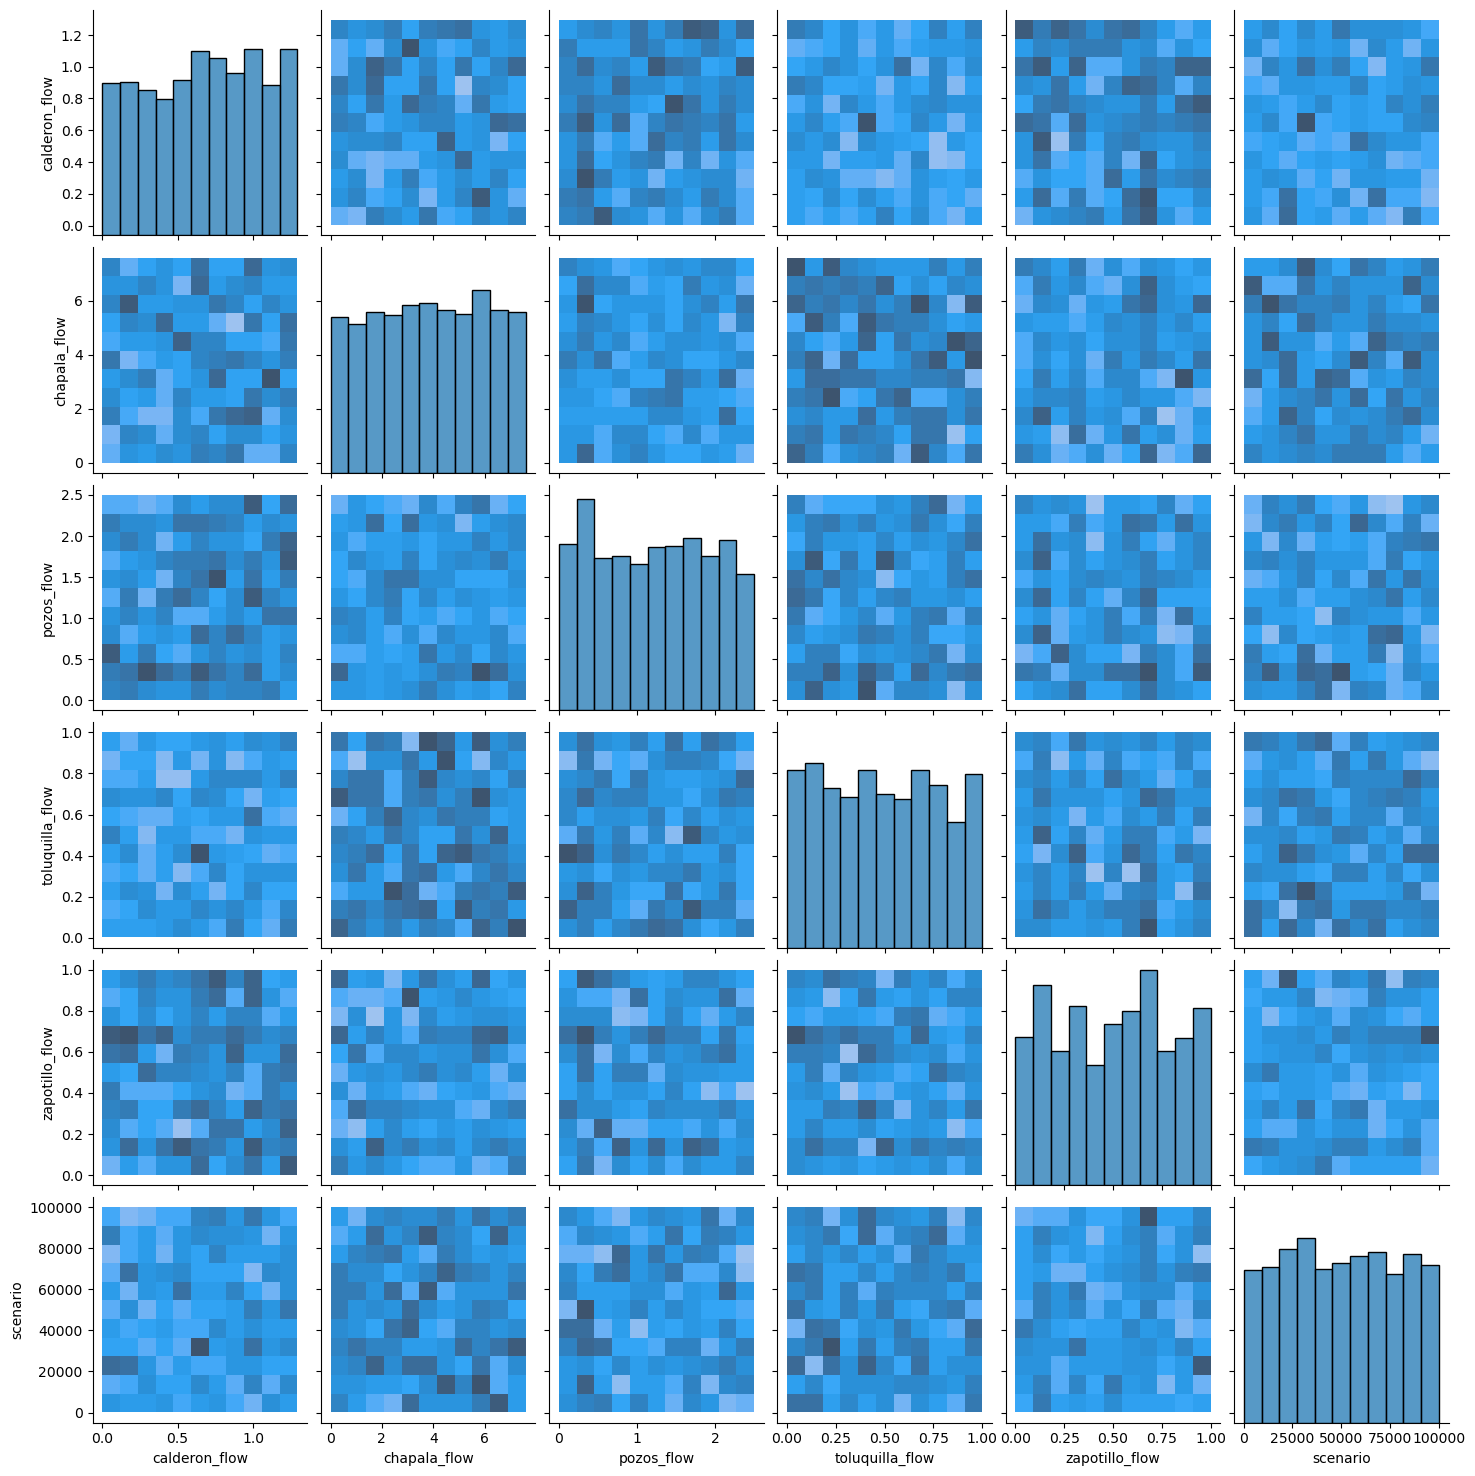

In [3]:
sns.pairplot(scenarios_data, kind="hist")

## 2. Optimization for scenario dataset based on objectives

In [4]:
from AMG_function import AMG_model_function

#performance_indicators = ["supplied_demand", "supply_percapita", "supplied_demand_deficit", "supply_deficit"]
#justice_indicators = ["supply_percapita_GINI", "supplied_demand_GINI", "ZAs_below_128", "ZAs_below_100", "ZAs_below_50"]

#Setting the stage
performance_indicator_to_maximize = ""
performance_indicator_to_minimize = ""
info_indicator = "supplied"
justice_indicator_to_minimize = 'ZAs_below_128'
pozos_to_toluquilla = 0 #set the max value of the segment of the aquapheric between pozos and toluquilla as the current physical restriction
n_scenarios = n_scenarios
n_nfe= 1000
epsilon = 1

experiment_name = f"{justice_indicator_to_minimize} {performance_indicator_to_minimize} {performance_indicator_to_maximize} - {n_scenarios} scenarios - {n_nfe}nfe epsilon {epsilon} - pozos to toluquilla {pozos_to_toluquilla}"

#ema_logging.log_to_stderr(ema_logging.INFO)

ZA_names = ["PP1", "PP2", "PP3", "Toluquilla", "Pozos"]

#instantiate the model
AMG_model = Model("AMGmodel", function = AMG_model_function)

#Levers

AMG_model.levers = [RealParameter('aqp1_PP2_to_PP3',-1,1),
                    RealParameter('aqp2_PP3_to_Pozos',-1,1),
                    RealParameter('aqp3_Pozos_to_Toluquilla',-1,pozos_to_toluquilla),
                    RealParameter('aqp4_Toluquilla_to_PP1',-1,1)] #Restriction of flow between posoz and toluquilla applied

#Outcomes


if performance_indicator_to_maximize == "":
    maximizing_outcomes = []
else: maximizing_outcomes = [f"{performance_indicator_to_maximize}_{ZA}" for ZA in ZA_names]
    
if performance_indicator_to_minimize == "":
    minimizing_outcomes = []
else: minimizing_outcomes = [f"{performance_indicator_to_minimize}_{ZA}" for ZA in ZA_names]

if info_indicator == "":
    info_outcomes = []
else: info_outcomes = [f"{info_indicator}_{ZA}" for ZA in ZA_names]


AMG_model.outcomes = [ScalarOutcome(scalar_outcome, kind=ScalarOutcome.MAXIMIZE) for scalar_outcome in maximizing_outcomes] + [
    ScalarOutcome(minimizing_outcome, kind=ScalarOutcome.MINIMIZE) for minimizing_outcome in minimizing_outcomes] + [
    ScalarOutcome(info_outcome, kind=ScalarOutcome.INFO) for info_outcome in info_outcomes] + [
    ScalarOutcome(justice_indicator_to_minimize, kind=ScalarOutcome.MINIMIZE)]

In [5]:
from ema_workbench import Scenario, Constraint
import pandas as pd
from tqdm import tqdm

flows = ["chapala_flow", "calderon_flow", "zapotillo_flow", "pozos_flow", "toluquilla_flow", "scenario"]

# Remove columns not used by the AMG model
scenarios_df = scenarios_data.drop(columns=["policy", "model"])

# Create an empty dataframe
optimization_results_df = pd.DataFrame()

# Use tqdm to create a progress bar for the loop
pbar = tqdm(total=scenarios_df.shape[0], desc="Optimizing Scenarios")

#Initialize random number generators
np.random.seed(1234)
random.seed(1234)

for index, row in scenarios_df.iterrows():
    # Create the Scenario object excluding the last column that has the name of the scenario
    scenario = Scenario(**row[:-1].to_dict())

    # Calculate how many optimizable outcomes there are
    n_outcomes = len(AMG_model.outcomes) - len(info_outcomes)

    # Constraints on the optimization
    non_negative_outcomes = [f"supplied_{ZA}" for ZA in ZA_names]  # using a list in case we add more in the future
    constraints = [Constraint("non_negative_constrain", outcome_names=outcome, 
                              function=lambda x: max(0, -x)) for outcome in non_negative_outcomes]  # lambda function gives 0 if x is negative

    with MultiprocessingEvaluator(AMG_model) as evaluator:
        np.random.seed(seed)
        results = evaluator.optimize(
            nfe=n_nfe, searchover="levers", epsilons=[epsilon] * n_outcomes, constraints=constraints, reference=scenario
        )
    
    # Get the name of the scenario from the last column of the segment
    results["scenario"] = row[-1]

    # Join the new row to the previous ones with the optimization for each scenario
    optimization_results_df = pd.concat([optimization_results_df, results], axis=0)

    # Update the progress bar
    pbar.update(1)

# Close the progress bar
pbar.close()

optimization_results_df.head()

Optimizing Scenarios:   0%|          | 0/1000 [00:00<?, ?it/s]

1075it [00:05, 192.19it/s]
1088it [00:05, 193.55it/s]|          | 1/1000 [00:07<1:58:47,  7.13s/it]
1081it [00:05, 205.74it/s]|          | 2/1000 [00:14<2:00:05,  7.22s/it]
1081it [00:05, 210.75it/s]|          | 3/1000 [00:21<1:55:50,  6.97s/it]
1078it [00:05, 214.56it/s]|          | 4/1000 [00:27<1:54:44,  6.91s/it]
1080it [00:04, 219.58it/s]|          | 5/1000 [00:34<1:51:26,  6.72s/it]
1074it [00:05, 208.44it/s]|          | 6/1000 [00:40<1:49:23,  6.60s/it]
1086it [00:05, 206.77it/s]|          | 7/1000 [00:47<1:48:39,  6.57s/it]
1077it [00:05, 201.74it/s]|          | 8/1000 [00:53<1:48:55,  6.59s/it]
1080it [00:05, 194.19it/s]                                                     
1078it [00:05, 200.68it/s]|          | 10/1000 [01:07<1:51:15,  6.74s/it]
1079it [00:05, 212.23it/s]|          | 11/1000 [01:14<1:51:02,  6.74s/it]
1077it [00:05, 191.13it/s]|          | 12/1000 [01:20<1:49:19,  6.64s/it]
1076it [00:05, 214.78it/s]|▏         | 13/1000 [01:27<1:52:08,  6.82s/it]
1079it [00:05

,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,aqp4_Toluquilla_to_PP1,ZAs_below_128,scenario
0,-0.635703,-0.904529,-0.997873,-0.924011,2,13504.0
0,-0.665968,-0.294175,-0.821934,-0.423864,2,72599.0
0,-0.063400,-0.451783,-0.287349,-0.203886,1,42217.0
0,-0.521800,-0.296223,-0.366220,0.081096,2,97650.0
0,0.054741,0.718173,-0.154651,-0.355702,0,99120.0


In [6]:
optimization_results_df.head(2)

,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,aqp4_Toluquilla_to_PP1,ZAs_below_128,scenario
0,-0.635703,-0.904529,-0.997873,-0.924011,2,13504.0
0,-0.665968,-0.294175,-0.821934,-0.423864,2,72599.0


In [7]:
scenarios_data.head(2)

,calderon_flow,chapala_flow,pozos_flow,toluquilla_flow,zapotillo_flow,scenario,policy,model
0,0.960307,4.252350,0.304787,0.861636,0.329354,13504,None,AMGmodel
1,0.575665,2.127411,1.394283,0.346133,0.865325,72599,None,AMGmodel


In [8]:
final_df = pd.merge(optimization_results_df, scenarios_data, on="scenario")
final_df.tail(3)

,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,aqp4_Toluquilla_to_PP1,ZAs_below_128,scenario,calderon_flow,chapala_flow,pozos_flow,toluquilla_flow,zapotillo_flow,policy,model
997,-0.601181,-0.059115,-0.200620,-0.705482,2,8879.0,1.068865,2.934291,0.030356,0.453644,0.833007,None,AMGmodel
998,-0.696155,-0.772248,-0.454669,-0.379722,3,30347.0,1.039121,1.805215,0.540115,0.006445,0.393673,None,AMGmodel
999,0.356490,-0.700245,-0.116168,-0.745560,3,15196.0,0.405931,2.922339,1.487040,0.125407,0.150232,None,AMGmodel


In [25]:
from data_functions import full_dataframe

full_df=full_dataframe(final_df, scenarios_in_dataframe= True, experiment_name=experiment_name)
full_df.head()
full_df.to_csv(f"experiment_results/{experiment_name}.csv", index=False)

## 3. Scenario discovery


### 3.1 For the dataframe created in this notebook

In [10]:
from ema_workbench.analysis import prim
from ema_workbench import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)


#loading the results from the 50l/day/person 1000 scenarios with restriction optimization
prim_df = full_df
#prim_df = pd.read_csv("experiment_results\ZAs_below_50  - 1000 scenarios - 1000nfe epsilon 1 - pozos to toluquilla 0.csv", index_col = [0])

all_columns = prim_df.columns
print(all_columns)

Index(['aqp4_Toluquilla_to_PP1', 'aqp1_PP2_to_PP3', 'aqp2_PP3_to_Pozos',
       'aqp3_Pozos_to_Toluquilla', 'chapala_flow', 'calderon_flow',
       'zapotillo_flow', 'pozos_flow', 'toluquilla_flow', 'scenario',
       'delivered_PP1', 'delivered_PP2', 'delivered_PP3',
       'delivered_Toluquilla', 'delivered_Pozos', 'supplied_PP1',
       'supplied_PP2', 'supplied_PP3', 'supplied_Toluquilla', 'supplied_Pozos',
       'total_supplied', 'demand_PP1', 'demand_PP2', 'demand_PP3',
       'demand_Toluquilla', 'demand_Pozos', 'supplied_demand_PP1',
       'supplied_demand_PP2', 'supplied_demand_PP3',
       'supplied_demand_Toluquilla', 'supplied_demand_Pozos',
       'supplied_demand_deficit_PP1', 'supplied_demand_deficit_PP2',
       'supplied_demand_deficit_PP3', 'supplied_demand_deficit_Toluquilla',
       'supplied_demand_deficit_Pozos', 'supply_percapita_PP1',
       'supply_percapita_PP2', 'supply_percapita_PP3',
       'supply_percapita_Toluquilla', 'supply_percapita_Pozos',
       '

c:\Users\ariel\anaconda3\envs\MBWSA\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive " "inspection not available"), ImportWarning)


#### 3.1.1 PRIM for the complete scenario space

In [11]:
prim_df.head(3)

,aqp4_Toluquilla_to_PP1,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,chapala_flow,calderon_flow,zapotillo_flow,pozos_flow,toluquilla_flow,scenario,...,supply_percapita_average,min_supplied_demand,supply_percapita_GINI,supplied_demand_GINI,average_supply_percapita,ZAs_below_128,ZAs_below_100,ZAs_below_50,scenario,experiment
0,-0.924011,-0.635703,-0.904529,-0.997873,4.252350,0.960307,0.329354,0.304787,0.861636,13504.0,...,114.0,0.17912,0.277895,0.281724,94.0,2.0,2.0,1.0,13504.0,ZAs_below_128 - 1000 scenarios - 1000nfe eps...
1,-0.423864,-0.665968,-0.294175,-0.821934,2.127411,0.575665,0.865325,1.394283,0.346133,72599.0,...,89.2,0.11967,0.294170,0.297360,76.0,2.0,2.0,2.0,72599.0,ZAs_below_128 - 1000 scenarios - 1000nfe eps...
2,-0.203886,-0.063400,-0.451783,-0.287349,5.825276,0.820116,0.381042,0.557090,0.926341,42217.0,...,125.0,0.14613,0.216320,0.216301,120.0,1.0,1.0,1.0,42217.0,ZAs_below_128 - 1000 scenarios - 1000nfe eps...


[MainProcess/INFO] 1000 points remaining, containing 100 cases of interest
[MainProcess/INFO] mean: 0.7592592592592593, mass: 0.054, coverage: 0.41, density: 0.7592592592592593 restricted_dimensions: 3


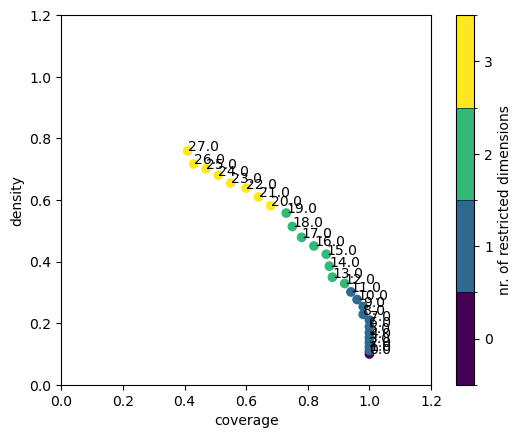

In [12]:
from ema_workbench.analysis import prim

#define an x with the data from the experiments (the uncertainties we want to search on)
x=prim_df.loc[:][['chapala_flow', 'calderon_flow',
       'zapotillo_flow', 'pozos_flow', 'toluquilla_flow',]]

quantile=0.9
variable_of_interest = "supply_percapita_GINI"
prim_df["scenario_of_interest"] = prim_df[variable_of_interest] > prim_df[variable_of_interest].quantile(quantile)

values_of_interest = prim_df.loc[:]["scenario_of_interest"]

#define a y with the variable of interest and convert it to a 1D array with values
y = values_of_interest.values



ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, y, threshold=0.5, peel_alpha=0.1)
box1 = prim_alg.find_box()
box1.show_tradeoff(annotated=True)
plt.show()

c:\Users\ariel\anaconda3\envs\MBWSA\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


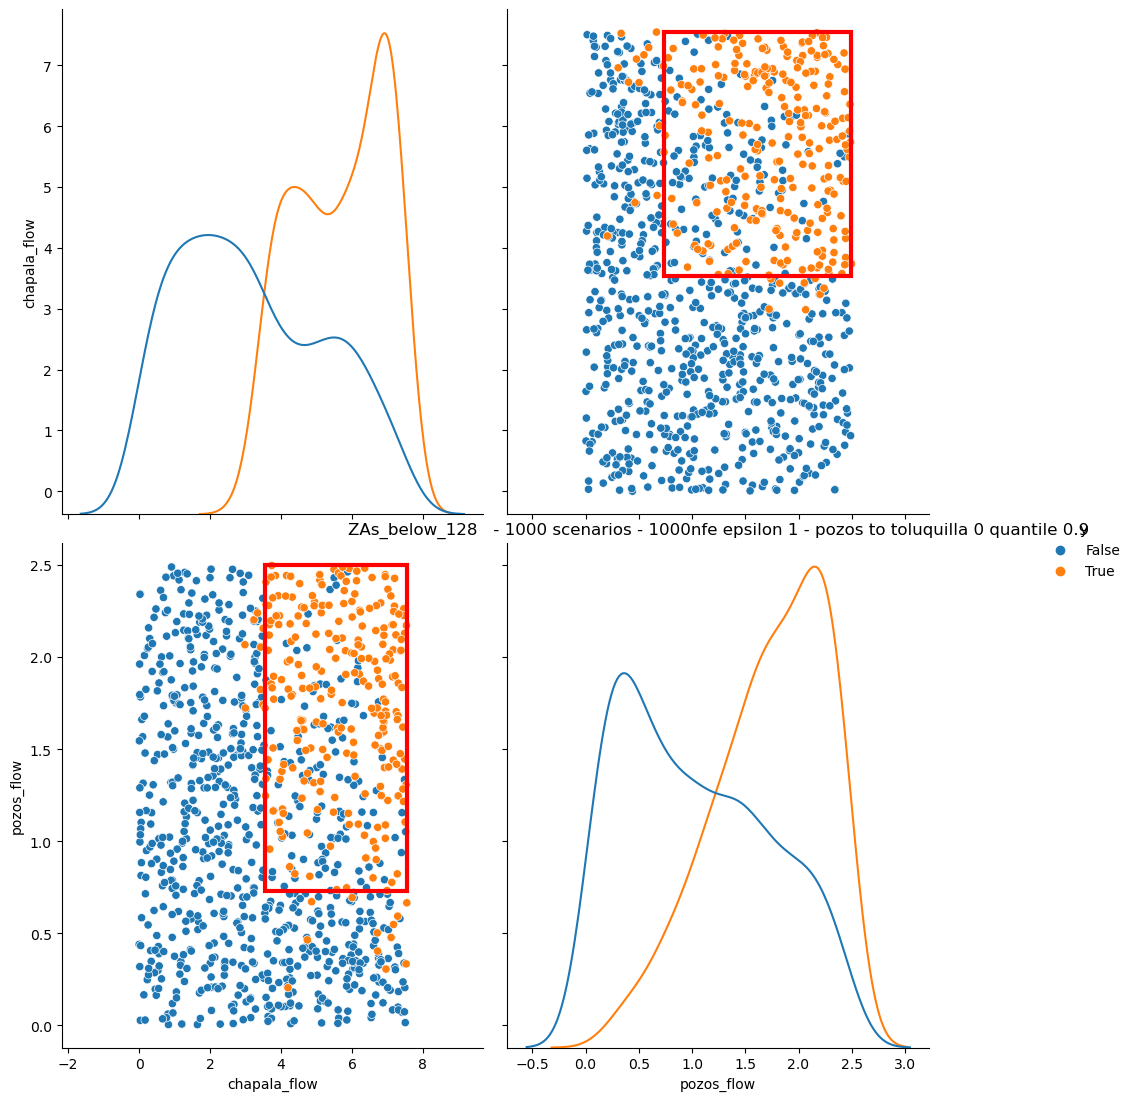

In [23]:
point = 20


import plotly.express as px
from itertools import cycle

box1.select(point)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.title(f"{experiment_name} quantile {quantile}")
plt.savefig(f"experiment_results/{experiment_name} quantile {quantile} PRIM ranges.jpg")
plt.show()



coverage    1.000000
density     0.209644
id          7.000000
mass        0.477000
mean        0.209644
res_dim     1.000000
Name: 7, dtype: float64

                 box 7                                 
                   min       max qp value      qp value
chapala_flow  0.000714  3.664964      NaN  1.008507e-12



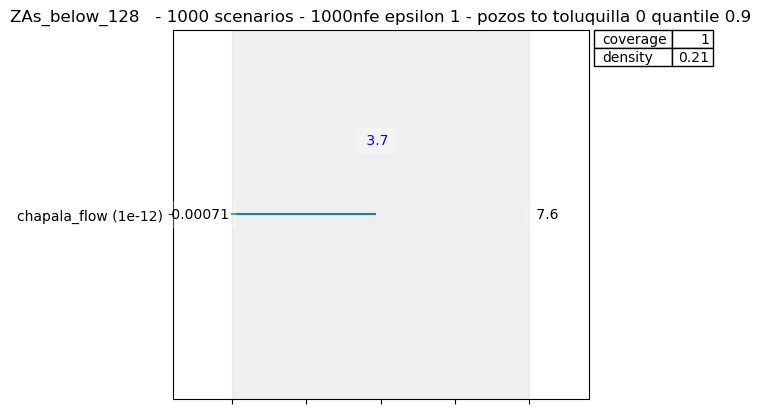

In [14]:
box1.inspect(point)
box1.inspect(point, style='graph')
plt.title(f"{experiment_name} quantile {quantile}")
plt.savefig(f"experiment_results/{experiment_name} quantile {quantile} PRIM box.jpg")
plt.show()



plt.show()

#### 3.1.2 PRIM for a supartitioned space where all the risky scenarios are

In [15]:
#define a dataframe with the range of chapala flow that 
#there's risk of not being able to meet the sufficientarian principle
chapala_risk_range = full_df.loc[full_df["ZAs_below_50"]>0][:]
chapala_risk_min_value = chapala_risk_range["chapala_flow"].max()
print(chapala_risk_min_value)
subspace_under50_risk = full_df.loc[full_df["chapala_flow"]<chapala_risk_min_value][:]
subspace_under50_risk.head()

7.550483035158123


,aqp4_Toluquilla_to_PP1,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,chapala_flow,calderon_flow,zapotillo_flow,pozos_flow,toluquilla_flow,scenario,...,min_supplied_demand,supply_percapita_GINI,supplied_demand_GINI,average_supply_percapita,ZAs_below_128,ZAs_below_100,ZAs_below_50,scenario,experiment,scenario_of_interest
0,-0.924011,-0.635703,-0.904529,-0.997873,4.252350,0.960307,0.329354,0.304787,0.861636,13504.0,...,0.17912,0.277895,0.281724,94.0,2.0,2.0,1.0,13504.0,ZAs_below_128 - 1000 scenarios - 1000nfe eps...,False
1,-0.423864,-0.665968,-0.294175,-0.821934,2.127411,0.575665,0.865325,1.394283,0.346133,72599.0,...,0.11967,0.294170,0.297360,76.0,2.0,2.0,2.0,72599.0,ZAs_below_128 - 1000 scenarios - 1000nfe eps...,False
2,-0.203886,-0.063400,-0.451783,-0.287349,5.825276,0.820116,0.381042,0.557090,0.926341,42217.0,...,0.14613,0.216320,0.216301,120.0,1.0,1.0,1.0,42217.0,ZAs_below_128 - 1000 scenarios - 1000nfe eps...,False
3,0.081096,-0.521800,-0.296223,-0.366220,5.887937,0.674427,0.658394,1.084134,0.045184,97650.0,...,0.12350,0.303915,0.305923,118.0,2.0,2.0,1.0,97650.0,ZAs_below_128 - 1000 scenarios - 1000nfe eps...,False
4,-0.355702,0.054741,0.718173,-0.154651,6.350443,1.169877,0.704051,1.032403,0.329324,99120.0,...,0.85414,0.007080,0.013768,135.0,0.0,0.0,0.0,99120.0,ZAs_below_128 - 1000 scenarios - 1000nfe eps...,False


[MainProcess/INFO] 996 points remaining, containing 260 cases of interest
[MainProcess/INFO] mean: 0.9590163934426229, mass: 0.12248995983935743, coverage: 0.45, density: 0.9590163934426229 restricted_dimensions: 5


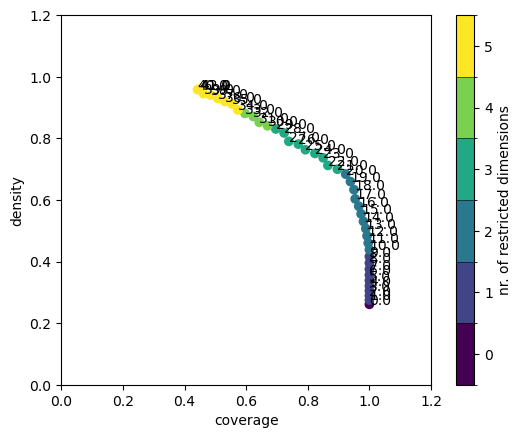

In [16]:
#define an x with the data from the experiments (the uncertainties we want to search on)
prim_df=subspace_under50_risk
x=prim_df.loc[:][['chapala_flow', 'calderon_flow',
       'zapotillo_flow', 'pozos_flow', 'toluquilla_flow',]]

variable_of_interest = "ZAs_below_50"
true_is = 0
false_is = [1,2,3,4,5]

values_of_interest = prim_df.loc[:][variable_of_interest].replace([true_is,false_is],[True, False])

#define a y with the variable of interest and convert it to a 1D array with values
y = values_of_interest.values



ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.05)
box1 = prim_alg.find_box()
box1.show_tradeoff(annotated=True)
plt.show()

In [17]:
point=32
box1.resample(point)

[MainProcess/INFO] resample 0


[MainProcess/INFO] resample 1
[MainProcess/INFO] resample 2
[MainProcess/INFO] resample 3
[MainProcess/INFO] resample 4
[MainProcess/INFO] resample 5
[MainProcess/INFO] resample 6
[MainProcess/INFO] resample 7
[MainProcess/INFO] resample 8
[MainProcess/INFO] resample 9


,reproduce coverage,reproduce density
chapala_flow,100.0,100.0
pozos_flow,100.0,100.0
calderon_flow,80.0,90.0
toluquilla_flow,70.0,70.0
zapotillo_flow,40.0,50.0


c:\Users\ariel\anaconda3\envs\MBWSA\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


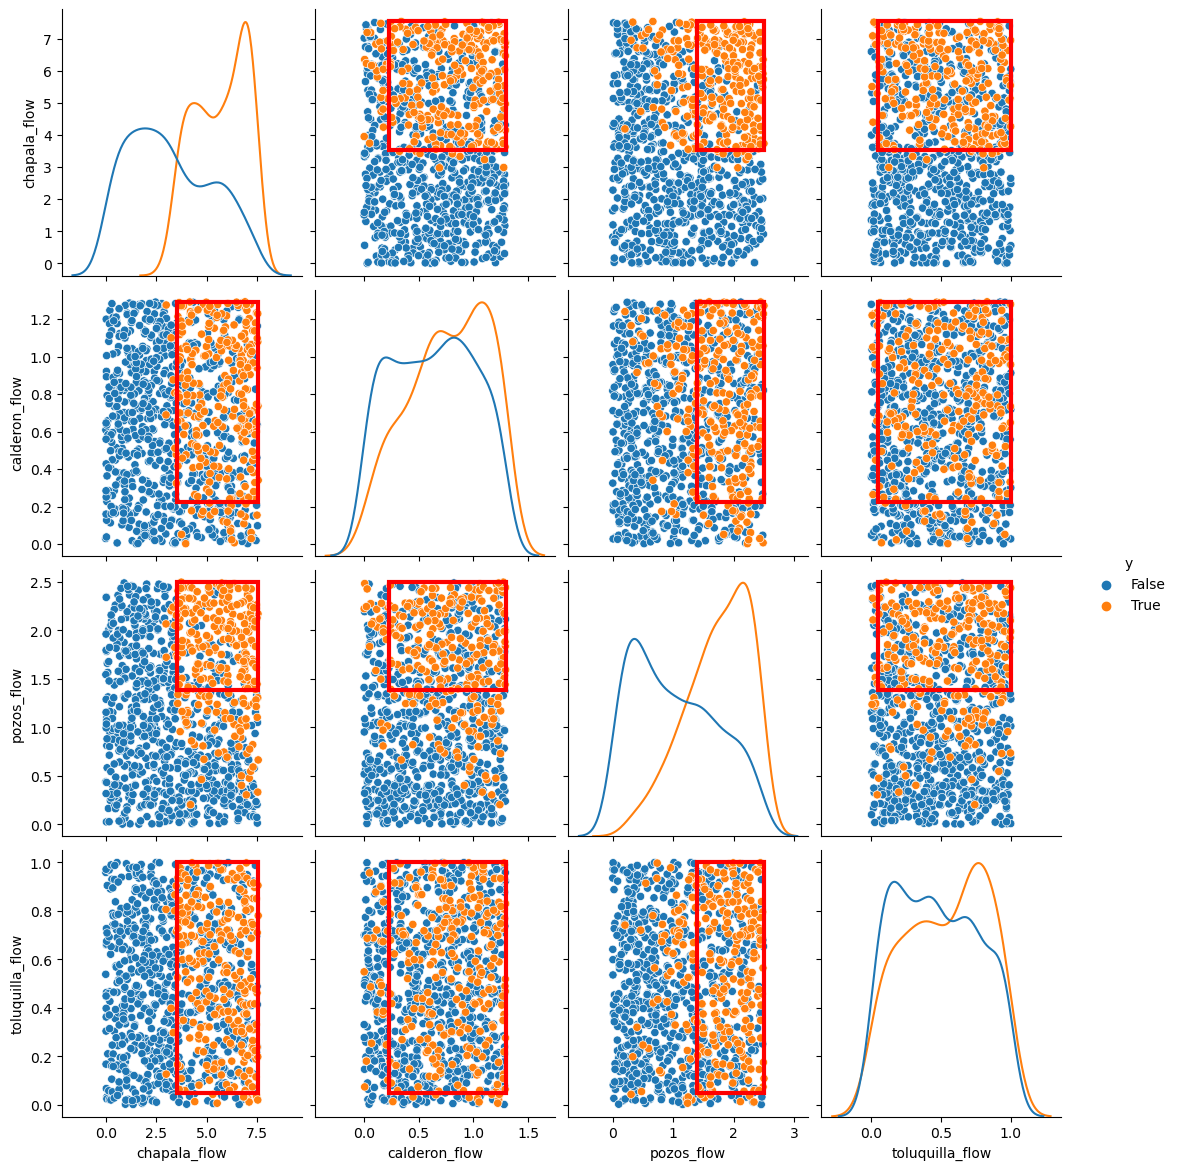

coverage     0.623077
density      0.870968
id          32.000000
mass         0.186747
mean         0.870968
res_dim      4.000000
Name: 32, dtype: float64

                   box 32                                 
                      min       max      qp value qp value
chapala_flow     3.534635  7.545618  9.625370e-29      NaN
pozos_flow       1.387846  2.497648  4.051056e-25      NaN
calderon_flow    0.226910  1.293210  2.055159e-02      NaN
toluquilla_flow  0.049723  0.999827  4.737676e-01      NaN



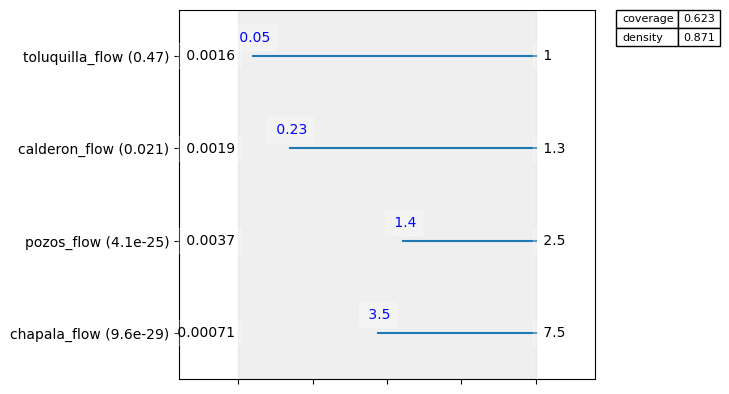

In [18]:

import plotly.express as px
from itertools import cycle

box1.select(point)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

box1.inspect(point)
box1.inspect(point, style='graph')
plt.show()

In [19]:
from ema_workbench.analysis import dimensional_stacking
#dimensional_stacking.create_pivot_plot(scenarios_data, y, nbins=4)

### 3.2 PRIM from a CSV file

In [20]:
from ema_workbench.analysis import prim
from ema_workbench import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)

sufficientarian_threshold = 100

#loading the results from the 50l/day/person 1000 scenarios with restriction optimization
full_df = pd.read_csv(f"experiment_results\ZAs_below_{sufficientarian_threshold}  - 1000 scenarios - 1000nfe epsilon 1 - pozos to toluquilla 0.csv", index_col = [0])
prim_df = full_df
prim_df.head()


,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,chapala_flow,calderon_flow,zapotillo_flow,pozos_flow,toluquilla_flow,scenario,delivered_PP1,...,supply_percapita_PP3,supply_percapita_Toluquilla,supply_percapita_Pozos,min_supplied_demand,supplied_demand_GINI,ZAs_below_128,ZAs_below_100,ZAs_below_50,scenario.1,experiment
aqp4_Toluquilla_to_PP1,,,,,,,,,,,,,,,,,,,,,
0.162864,-0.345083,-0.132457,-0.212883,4.252350,0.960307,0.329354,0.304787,0.861636,113504.0,3.444403,...,113.0,100.0,25.0,0.17213,0.201541,4.0,1.0,1.0,113504.0,ZAs_below_100 - 1000 scenarios - 1000nfe epsi...
-0.488937,-0.439038,0.248719,-0.156763,2.127411,0.575665,0.865325,1.394283,0.346133,172599.0,1.723203,...,100.0,107.0,118.0,0.20419,0.167824,5.0,1.0,1.0,172599.0,ZAs_below_100 - 1000 scenarios - 1000nfe epsi...
-0.344106,0.048068,0.124289,-0.728582,5.825276,0.820116,0.381042,0.557090,0.926341,142217.0,4.718474,...,124.0,125.0,102.0,0.69651,0.036012,5.0,0.0,0.0,142217.0,ZAs_below_100 - 1000 scenarios - 1000nfe epsi...
-0.740789,-0.051921,0.438396,-0.272512,5.887937,0.674427,0.658394,1.084134,0.045184,197650.0,4.769229,...,104.0,131.0,123.0,0.66552,0.072229,3.0,0.0,0.0,197650.0,ZAs_below_100 - 1000 scenarios - 1000nfe epsi...
-0.534572,-0.031061,0.520677,-0.255459,6.350443,1.169877,0.704051,1.032403,0.329324,199120.0,5.143859,...,150.0,145.0,125.0,0.81450,0.041350,1.0,0.0,0.0,199120.0,ZAs_below_100 - 1000 scenarios - 1000nfe epsi...


In [21]:
    
light_grey_data = prim_df.loc[:][['chapala_flow', 'calderon_flow',
       'zapotillo_flow', 'pozos_flow', 'toluquilla_flow']]

colored_data = prim_df.loc[prim_df[f"ZAs_below_{sufficientarian_threshold}"]>0][['chapala_flow', 'calderon_flow',
       'zapotillo_flow', 'pozos_flow', 'toluquilla_flow']]

plot_colored_parallel_axis(light_grey_data=light_grey_data, colored_data=colored_data, color="black")

NameError: name 'plot_colored_parallel_axis' is not defined

[MainProcess/INFO] 1000 points remaining, containing 647 cases of interest


[MainProcess/INFO] mean: 1.0, mass: 0.409, coverage: 0.6321483771251932, density: 1.0 restricted_dimensions: 1


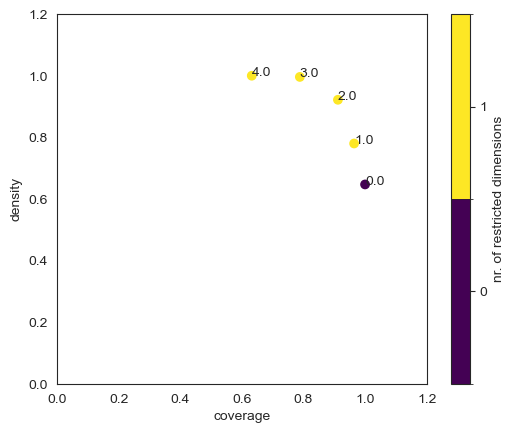

In [ ]:
from ema_workbench.analysis import prim

#define an x with the data from the experiments (the uncertainties we want to search on)
x=prim_df.loc[:][['chapala_flow', 'calderon_flow',
       'zapotillo_flow', 'pozos_flow', 'toluquilla_flow',]]

variable_of_interest = f"ZAs_below_{sufficientarian_threshold}"

#Cases where there are no solutions where the sufficientarian threshold is met for all ZAs
false_is = 0 #sufficientarian objective is met (no ZA is under threshold)
true_is = [1,2,3,4,5] #sufficientarian objective is not met (there are at least 1 ZA under threshold)

values_of_interest = prim_df.loc[:][variable_of_interest].replace([true_is,false_is],[True, False])

#define a y with the variable of interest and convert it to a 1D array with values
y = values_of_interest.values



ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.2) #values selected in order to have a readable plot
box1 = prim_alg.find_box()
box1.show_tradeoff(annotated=True)
plt.show()

c:\Users\ariel\anaconda3\envs\MBWSA\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


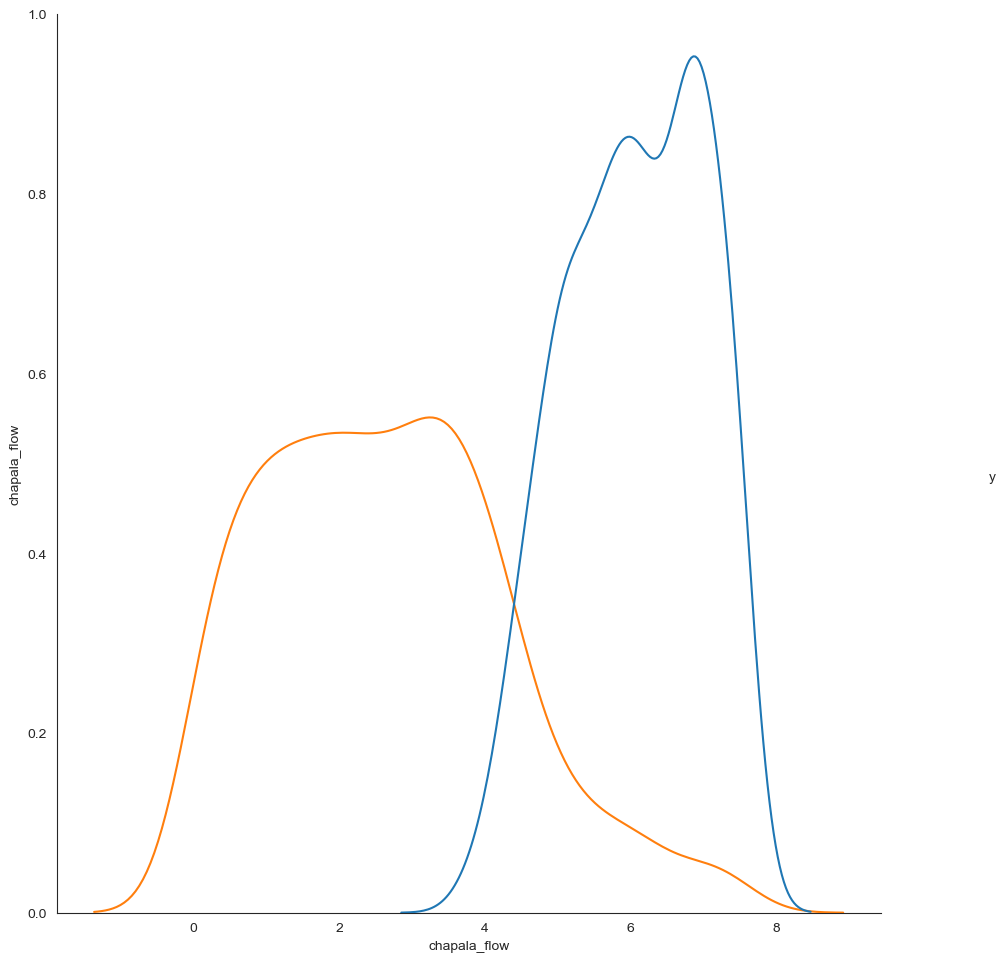

coverage    0.964451
density     0.780000
id          1.000000
mass        0.800000
mean        0.780000
res_dim     1.000000
Name: 1, dtype: float64

                 box 1                                 
                   min       max qp value      qp value
chapala_flow  0.000714  6.079904      NaN  2.103286e-16



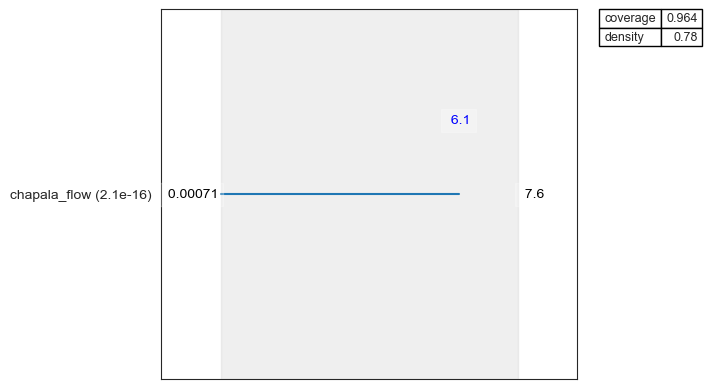

In [ ]:
point = 1 #selected as the higest density without loosing coverage
box1.select(point)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()
box1.inspect(point)
box1.inspect(point, style='graph')
plt.show()



As it is shown in the plot above, CHapala is the main variable that determines if the sufficientarian threshold is being met. If Chapala flow is under the value above, it is highly likely that the sufficientarian objective is not being met.

Lets further explore if there are cases where chapala flow is high bu

If Chapala Flow is above 7.55m3/s there's always a solution to ensure every ZA is above 50l/day


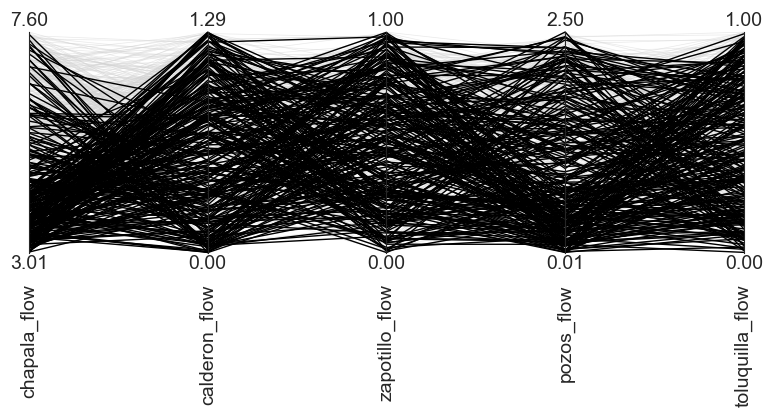

,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,chapala_flow,calderon_flow,zapotillo_flow,pozos_flow,toluquilla_flow,scenario,delivered_PP1,...,supply_percapita_PP3,supply_percapita_Toluquilla,supply_percapita_Pozos,min_supplied_demand,supplied_demand_GINI,ZAs_below_128,ZAs_below_100,ZAs_below_50,scenario.1,experiment
aqp4_Toluquilla_to_PP1,,,,,,,,,,,,,,,,,,,,,
0.162864,-0.345083,-0.132457,-0.212883,4.252350,0.960307,0.329354,0.304787,0.861636,113504.0,3.444403,...,113.0,100.0,25.0,0.17213,0.201541,4.0,1.0,1.0,113504.0,ZAs_below_100 - 1000 scenarios - 1000nfe epsi...
-0.344106,0.048068,0.124289,-0.728582,5.825276,0.820116,0.381042,0.557090,0.926341,142217.0,4.718474,...,124.0,125.0,102.0,0.69651,0.036012,5.0,0.0,0.0,142217.0,ZAs_below_100 - 1000 scenarios - 1000nfe epsi...
-0.740789,-0.051921,0.438396,-0.272512,5.887937,0.674427,0.658394,1.084134,0.045184,197650.0,4.769229,...,104.0,131.0,123.0,0.66552,0.072229,3.0,0.0,0.0,197650.0,ZAs_below_100 - 1000 scenarios - 1000nfe epsi...
-0.534572,-0.031061,0.520677,-0.255459,6.350443,1.169877,0.704051,1.032403,0.329324,199120.0,5.143859,...,150.0,145.0,125.0,0.81450,0.041350,1.0,0.0,0.0,199120.0,ZAs_below_100 - 1000 scenarios - 1000nfe epsi...
-0.653670,0.460763,0.398796,-0.681633,7.315311,0.481453,0.403816,0.389745,0.537444,113165.0,5.925402,...,104.0,140.0,110.0,0.66358,0.078368,3.0,0.0,0.0,113165.0,ZAs_below_100 - 1000 scenarios - 1000nfe epsi...


In [ ]:


#Create a dataframe with only the scenarios with no sufficientarian solution
chapala_risk_range = full_df.loc[full_df[f"ZAs_below_{sufficientarian_threshold}"]>0][:]

#check what is the maximum 
chapala_risk_min_value = chapala_risk_range["chapala_flow"].max()
print(f"If Chapala Flow is above {round(chapala_risk_min_value,2)}m3/s there's always a solution to ensure every ZA is above 50l/day")
subspace_under50_risk = full_df.loc[full_df["chapala_flow"]<chapala_risk_min_value][:]
subspace_under50_risk = full_df.loc[full_df["chapala_flow"]>3][:]

plot_df = subspace_under50_risk

light_grey_data = plot_df.loc[:][['chapala_flow', 'calderon_flow',
       'zapotillo_flow', 'pozos_flow', 'toluquilla_flow']]

colored_data = plot_df.loc[plot_df[f"ZAs_below_{sufficientarian_threshold}"]>0][['chapala_flow', 'calderon_flow',
       'zapotillo_flow', 'pozos_flow', 'toluquilla_flow']]

plot_colored_parallel_axis(light_grey_data=light_grey_data, colored_data=colored_data, color="black")



subspace_under50_risk.head()

[MainProcess/INFO] 616 points remaining, containing 446 cases of interest


[MainProcess/INFO] mean: 0.9955947136563876, mass: 0.3685064935064935, coverage: 0.5067264573991032, density: 0.9955947136563876 restricted_dimensions: 4


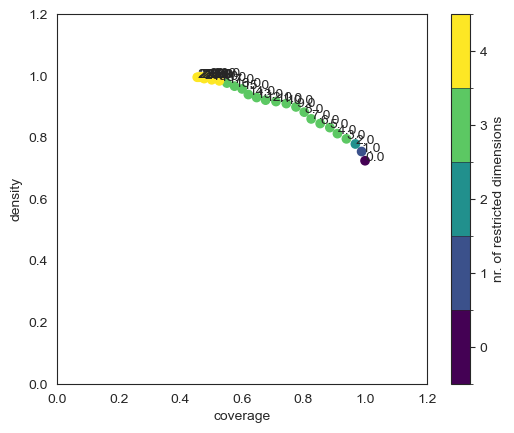

In [ ]:
#define an x with the data from the experiments (the uncertainties we want to search on)
prim_df=subspace_under50_risk
x=prim_df.loc[:][['chapala_flow', 'calderon_flow',
       'zapotillo_flow', 'pozos_flow', 'toluquilla_flow',]]

variable_of_interest = "ZAs_below_50"
true_is = 0
false_is = [1,2,3,4,5]

values_of_interest = prim_df.loc[:][variable_of_interest].replace([true_is,false_is],[True, False])

#define a y with the variable of interest and convert it to a 1D array with values
y = values_of_interest.values



ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.05)
box1 = prim_alg.find_box()
box1.show_tradeoff(annotated=True)
plt.show()

In [ ]:
point=3
box1.resample(point)

[MainProcess/INFO] resample 0
[MainProcess/INFO] resample 1
[MainProcess/INFO] resample 2
[MainProcess/INFO] resample 3
[MainProcess/INFO] resample 4
[MainProcess/INFO] resample 5
[MainProcess/INFO] resample 6
[MainProcess/INFO] resample 7
[MainProcess/INFO] resample 8
[MainProcess/INFO] resample 9


,reproduce coverage,reproduce density
chapala_flow,100.0,100.0
pozos_flow,80.0,80.0
calderon_flow,50.0,60.0
zapotillo_flow,0.0,0.0
toluquilla_flow,0.0,0.0


c:\Users\ariel\anaconda3\envs\MBWSA\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


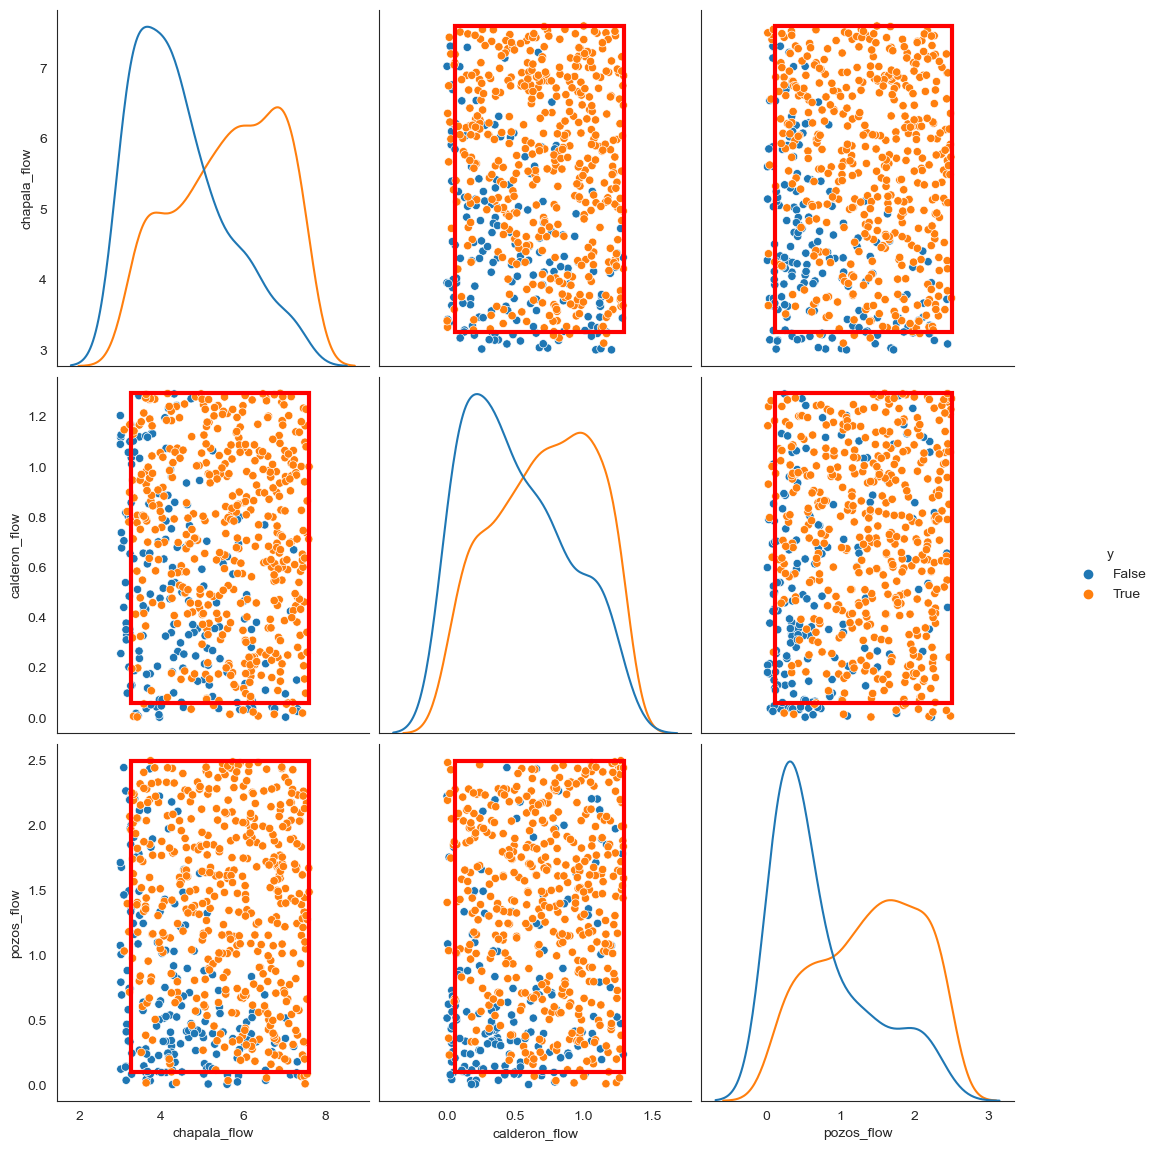

coverage    0.939462
density     0.795066
id          3.000000
mass        0.855519
mean        0.795066
res_dim     3.000000
Name: 3, dtype: float64

                  box 3                             
                    min       max  qp value qp value
chapala_flow   3.258535  7.599040  0.036562      NaN
pozos_flow     0.108886  2.497648  0.118107      NaN
calderon_flow  0.057266  1.293210  0.192806      NaN



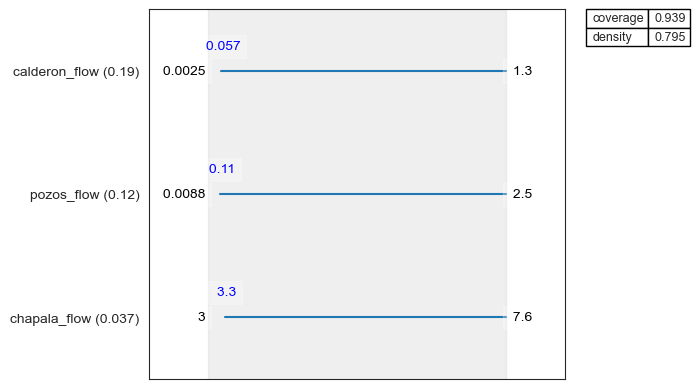

In [ ]:

import plotly.express as px
from itertools import cycle

box1.select(point)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

box1.inspect(point)
box1.inspect(point, style='graph')
plt.show()